# Figures from models

In [2]:
import pystan
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

az.style.use('arviz-darkgrid')

df = pd.read_csv('../data/raw/train.csv')

In [3]:
def z_std(x):
    z_score = (x - x.mean()) / x.std()
    return(z_score)

df['log_sales_price'] = np.log(df['SalePrice'])
df['log_lot_area'] = np.log(df['LotArea'])

df['log_sales_price_z'] = z_std(df[['log_sales_price']])
df['log_lot_area_z'] = z_std(df[['log_lot_area']])

#df['log_sales_price_std'] = df['log_sales_price']/df['log_sales_price'].mean()

df['neighbourhood'] = df['Neighborhood'].astype('category').cat.codes+1

In [32]:
int(1000.43)

1000

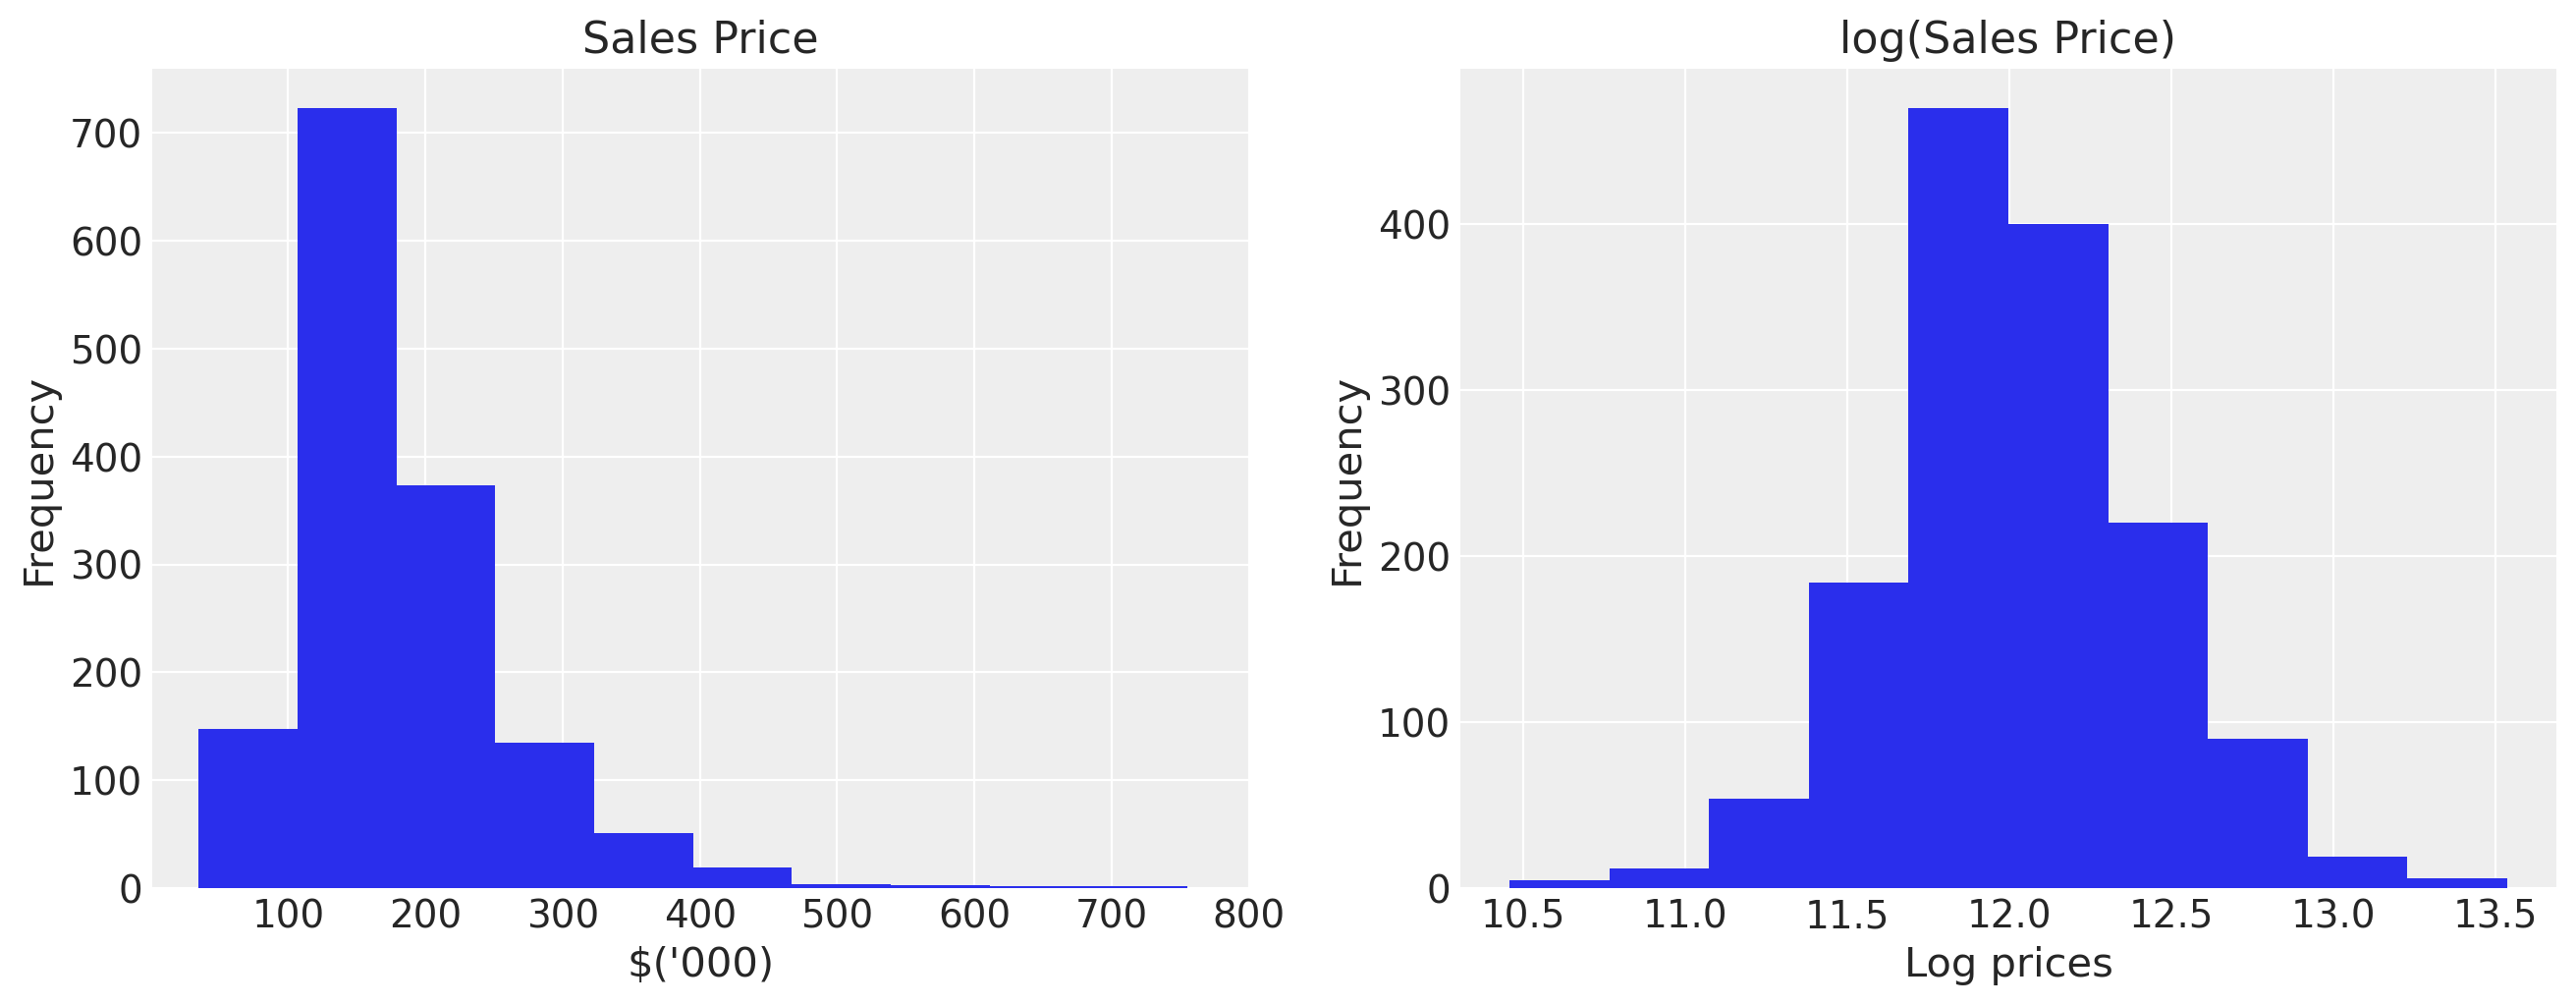

In [50]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize = (13, 5))
df['SalePrice'].plot.hist(title = 'Sales Price', ax = axes[0])
np.log(df['SalePrice']).plot.hist(title = 'log(Sales Price)', ax = axes[1])

# Adjust x axis on both plots
axes[0].set_xlim(1000, 800000)
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(x/1000))))
axes[0].set_xlabel("$('000)")

axes[1].set_xlabel("Log prices")

plt.savefig('figures/1_histograms.svg', dpi=300)

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


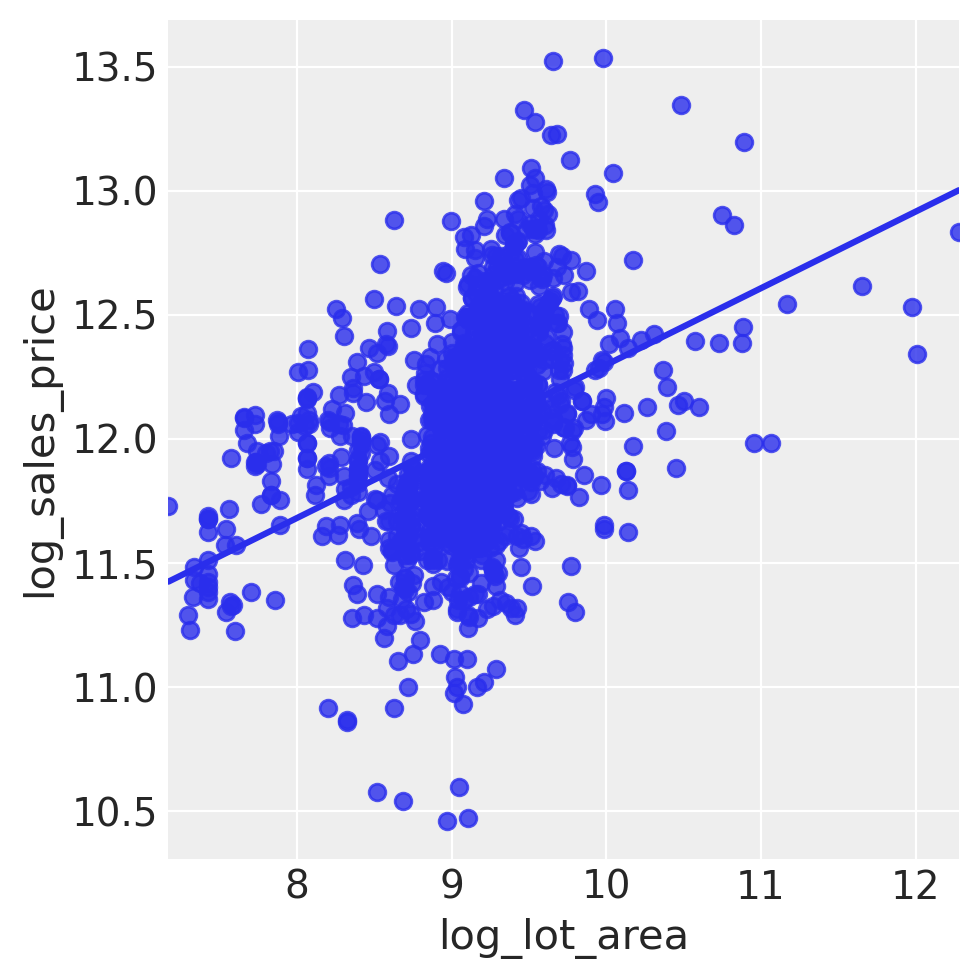

In [60]:
sns.lmplot(x='log_lot_area',y='log_sales_price',data=df,fit_reg=True, ci = False)
plt.tight_layout()

plt.savefig('figures/2_pooling_scatter.svg', dpi=300)

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


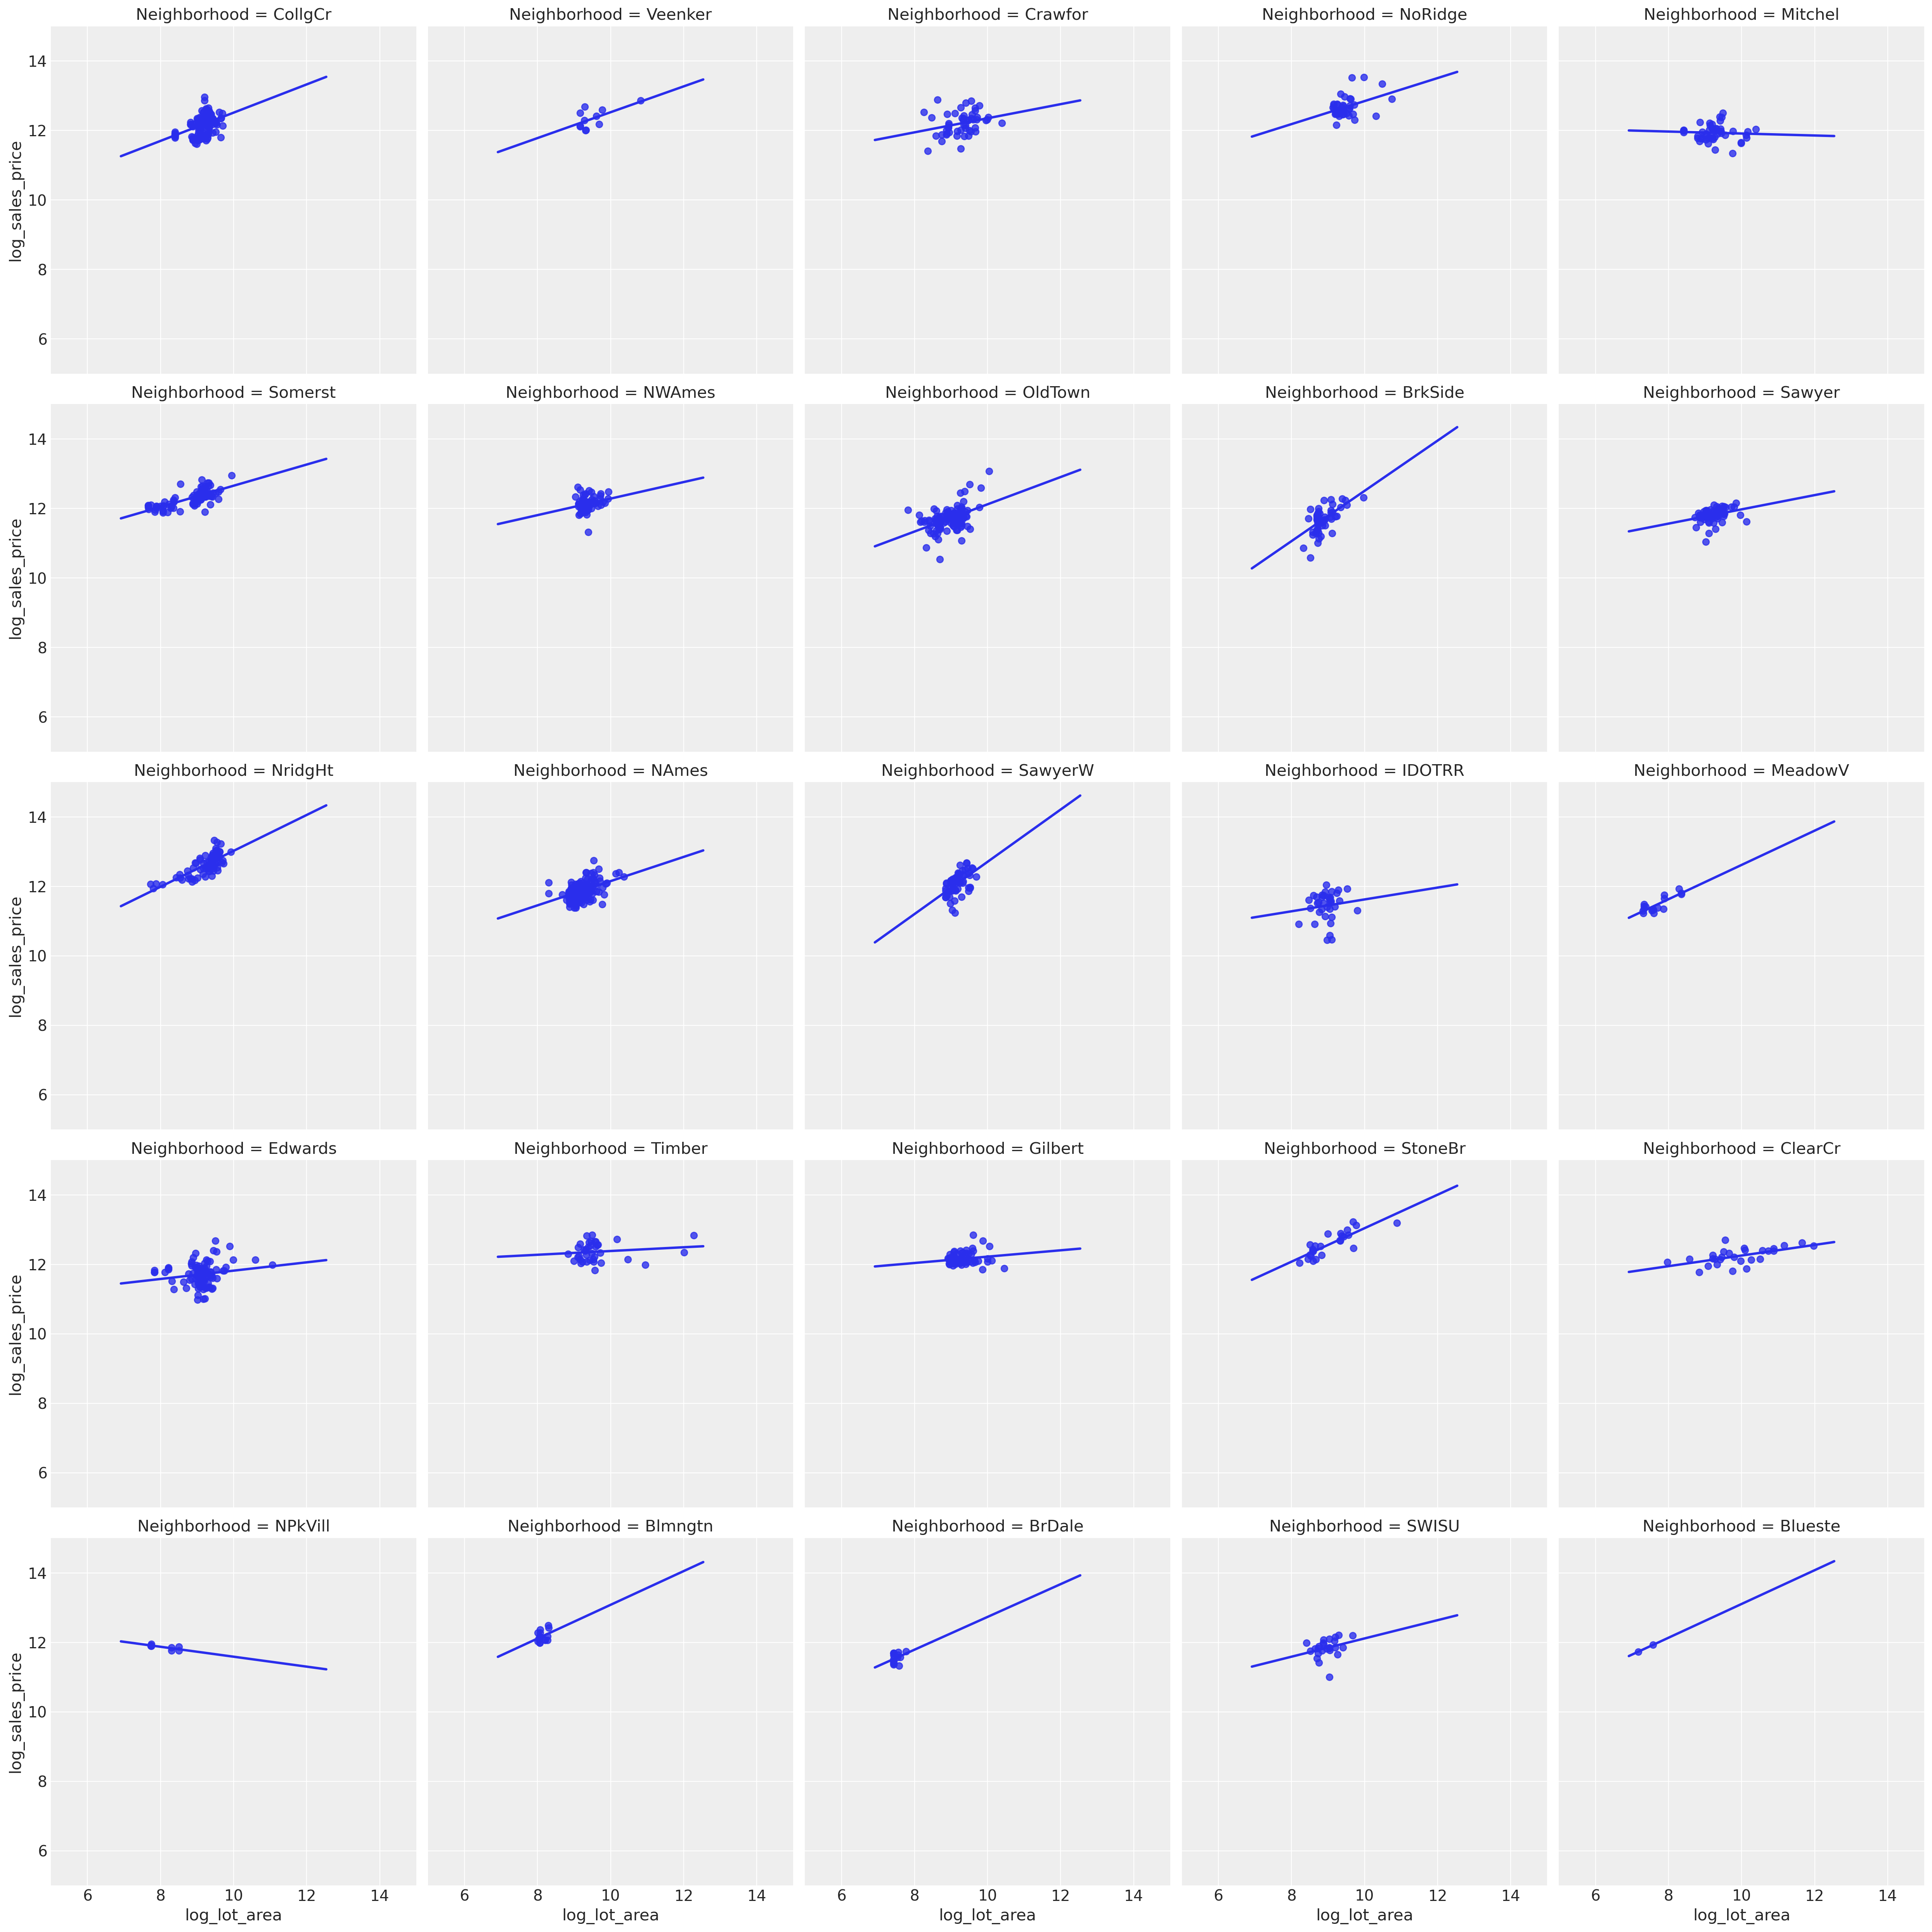

In [64]:
facet_scatter = sns.lmplot(x="log_lot_area", 
                           y="log_sales_price", 
                           col="Neighborhood",
                           col_wrap = 5,
                           data=df,
                           ci = None, 
                           truncate=False)

facet_scatter.set(xlim=(5, 15))
facet_scatter.set(ylim=(5, 15))
plt.tight_layout()

plt.savefig('figures/3_facet_scatter.svg', dpi=300)

In [17]:
no_pooling_model = pystan.StanModel(file = '../models/blog_code.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af92883bc8d3d44dd8d45bffd5860aca NOW.


In [18]:
npm_data_check = dict(N = len(df),
                      log_sales_price = df['log_sales_price_z'],
                      log_lot_area = df['log_lot_area_z'],
                      neighbourhood = df['neighbourhood'],
                      N_neighbourhood = len(df['Neighborhood'].unique()),
                      alpha_sd = 1, 
                      beta_sd = 1, 
                      run_estimation = 0)

fit_npm_check = no_pooling_model.sampling(data=npm_data_check)
npm_df_check = fit_npm_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


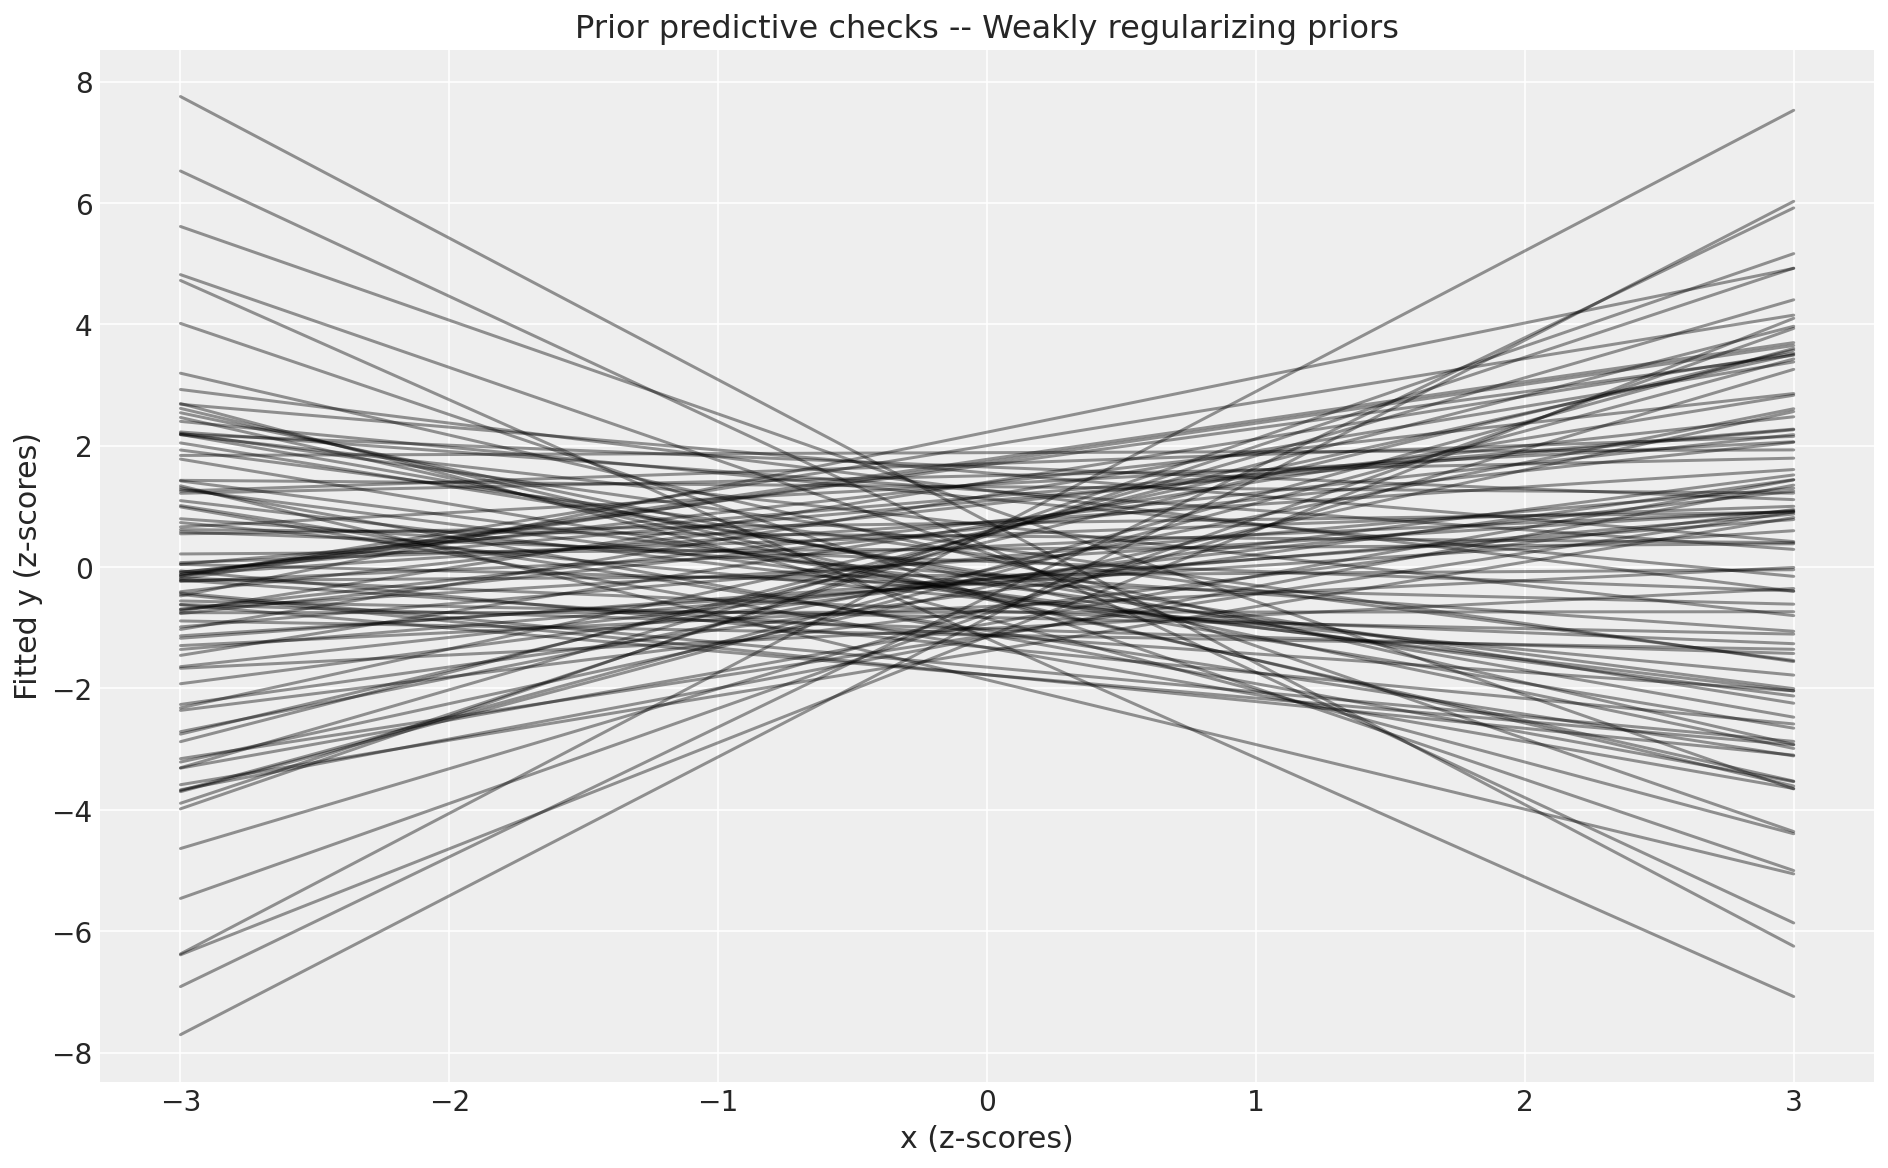

In [22]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, beta in zip(npm_df_check["alpha[4]"][:100], npm_df_check["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors")
plt.savefig('figures/4_prior_predictive_check.svg', dpi=300);

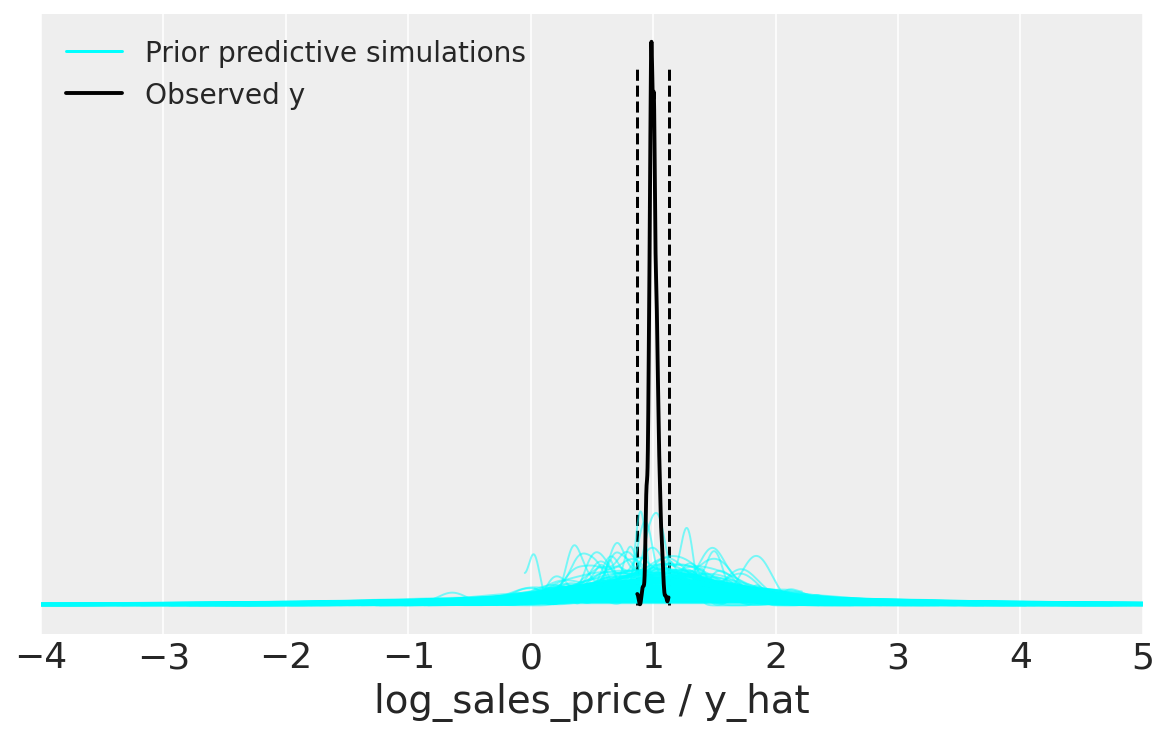

In [99]:
npm_check_az = az.from_pystan(
    posterior=fit_npm_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)


az.plot_ppc(data = npm_check_az, 
            kind = 'kde', 
            data_pairs = {'log_sales_price' : 'y_hat'},
            legend = False,
            color='cyan',
            mean = False,
            figsize=(8, 5),
            alpha = 0.5,
            num_pp_samples=200)

plt.xlim(-4, 5)
plt.legend(['Prior predictive simulations', 'Observed y'])
plt.vlines(x=df['log_sales_price_std'].min(), ymin=0, ymax=13,color='black', linestyles='dashed')
plt.vlines(x=df['log_sales_price_std'].max(), ymin=0, ymax=13,color='black', linestyles='dashed')
#plt.savefig('figures/4_prior_predictive_check.svg', dpi=300);

In [12]:
npm_data_check_wide = dict(N = len(df),
                      log_sales_price = df['log_sales_price_std'],
                      log_lot_area = df['log_lot_area_z'],
                      neighbourhood = df['neighbourhood'],
                      N_neighbourhood = len(df['Neighborhood'].unique()),
                      alpha_sd = 10, 
                      beta_sd = 10, 
                      run_estimation = 0)

fit_npm_check_wide = no_pooling_model.sampling(data=npm_data_check_wide)
npm_df_check_wide = fit_npm_check_wide.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


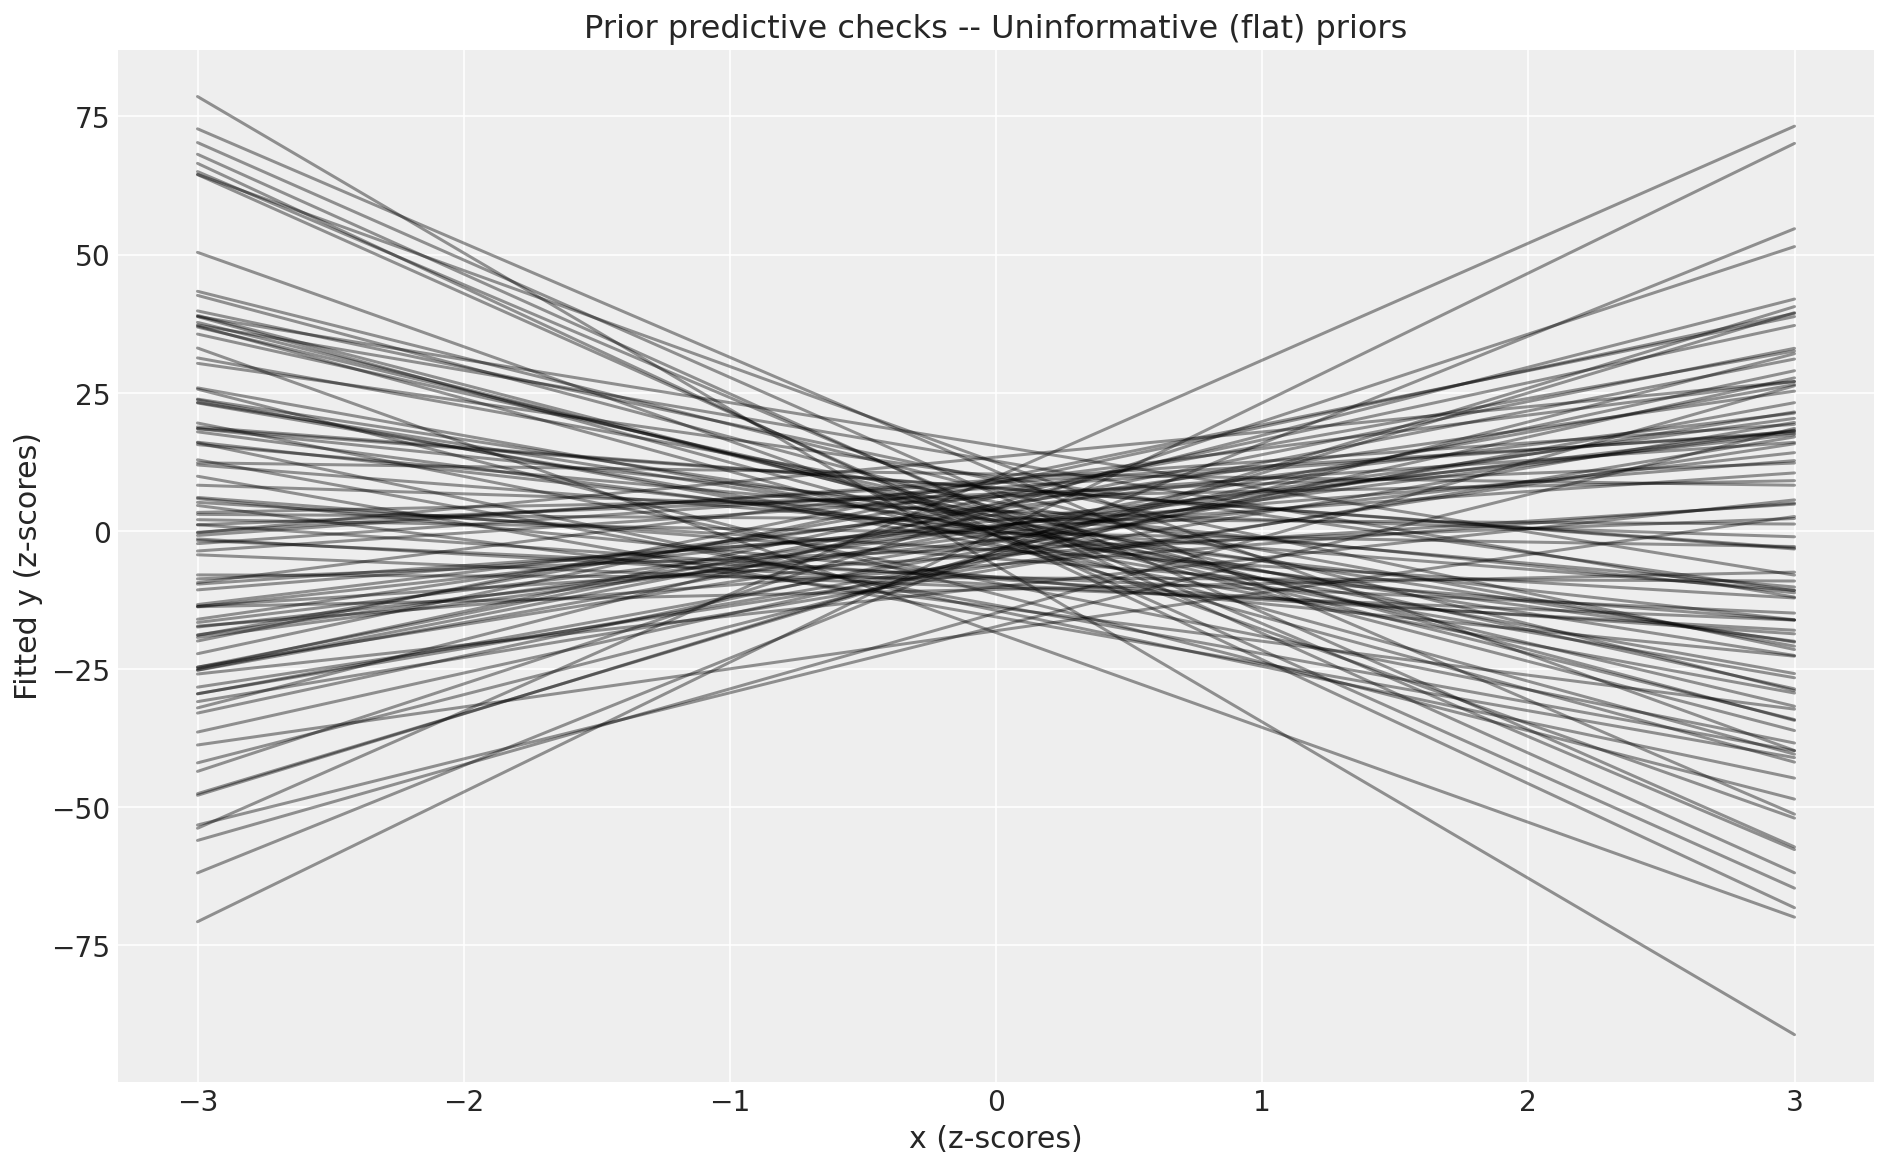

In [23]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, beta in zip(npm_df_check_wide["alpha[4]"][:100], npm_df_check_wide["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Uninformative (flat) priors")
plt.savefig('figures/5_prior_predictive_check_wide.svg', dpi=300);

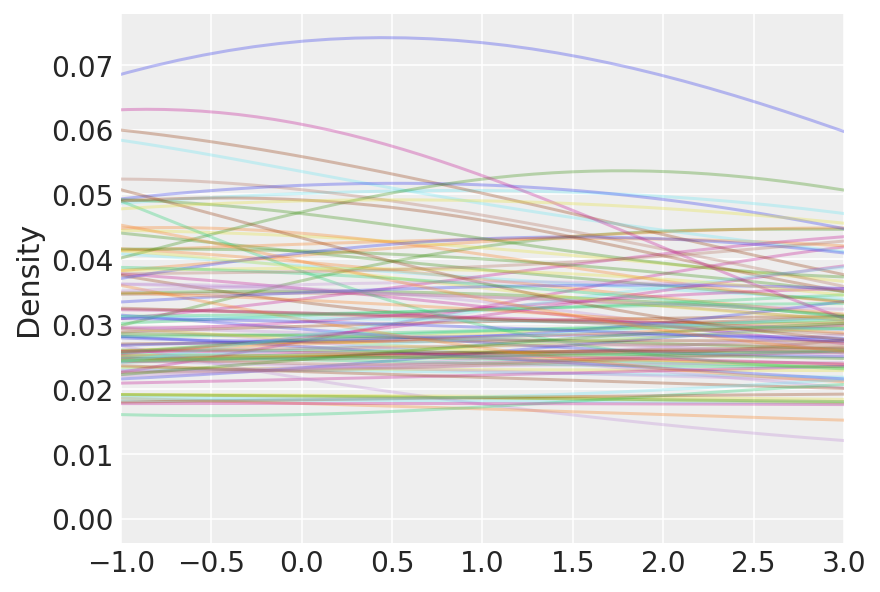

In [21]:
fig, axes = plt.subplots(1,1)

npm_df_check_wide.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-1, 3),
                                                        ax = axes);

#plt.vlines(x=df['log_sales_price_std'].min(), ymin=0, ymax=1,color='black', linestyles='dashed')
#plt.vlines(x=df['log_sales_price_std'].max(), ymin=0, ymax=1,color='black', linestyles='dashed')

#plt.savefig('figures/5_prior_predictive_check_wide.svg', dpi=300);

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

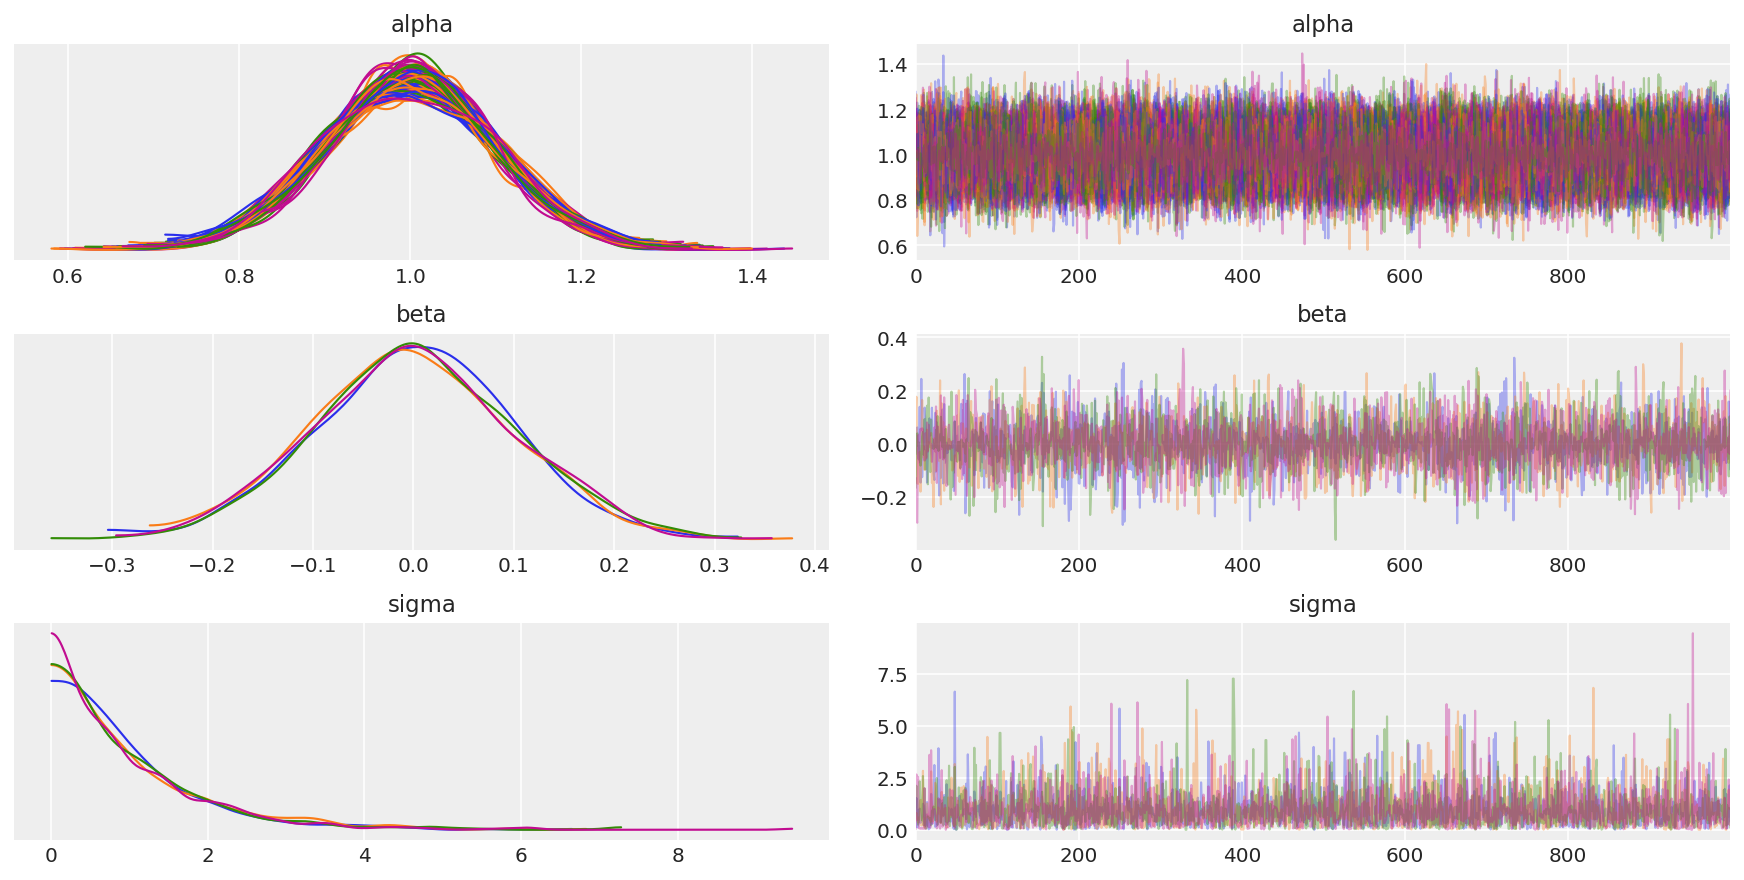

In [102]:
# Inspect model fit
az.plot_trace(fit_npm_check_wide, 
              var_names=["alpha", "beta", "sigma"], 
              compact = True, 
              chain_prop = 'color')

#plt.savefig('figures/7_trace_plot.svg', dpi=300);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


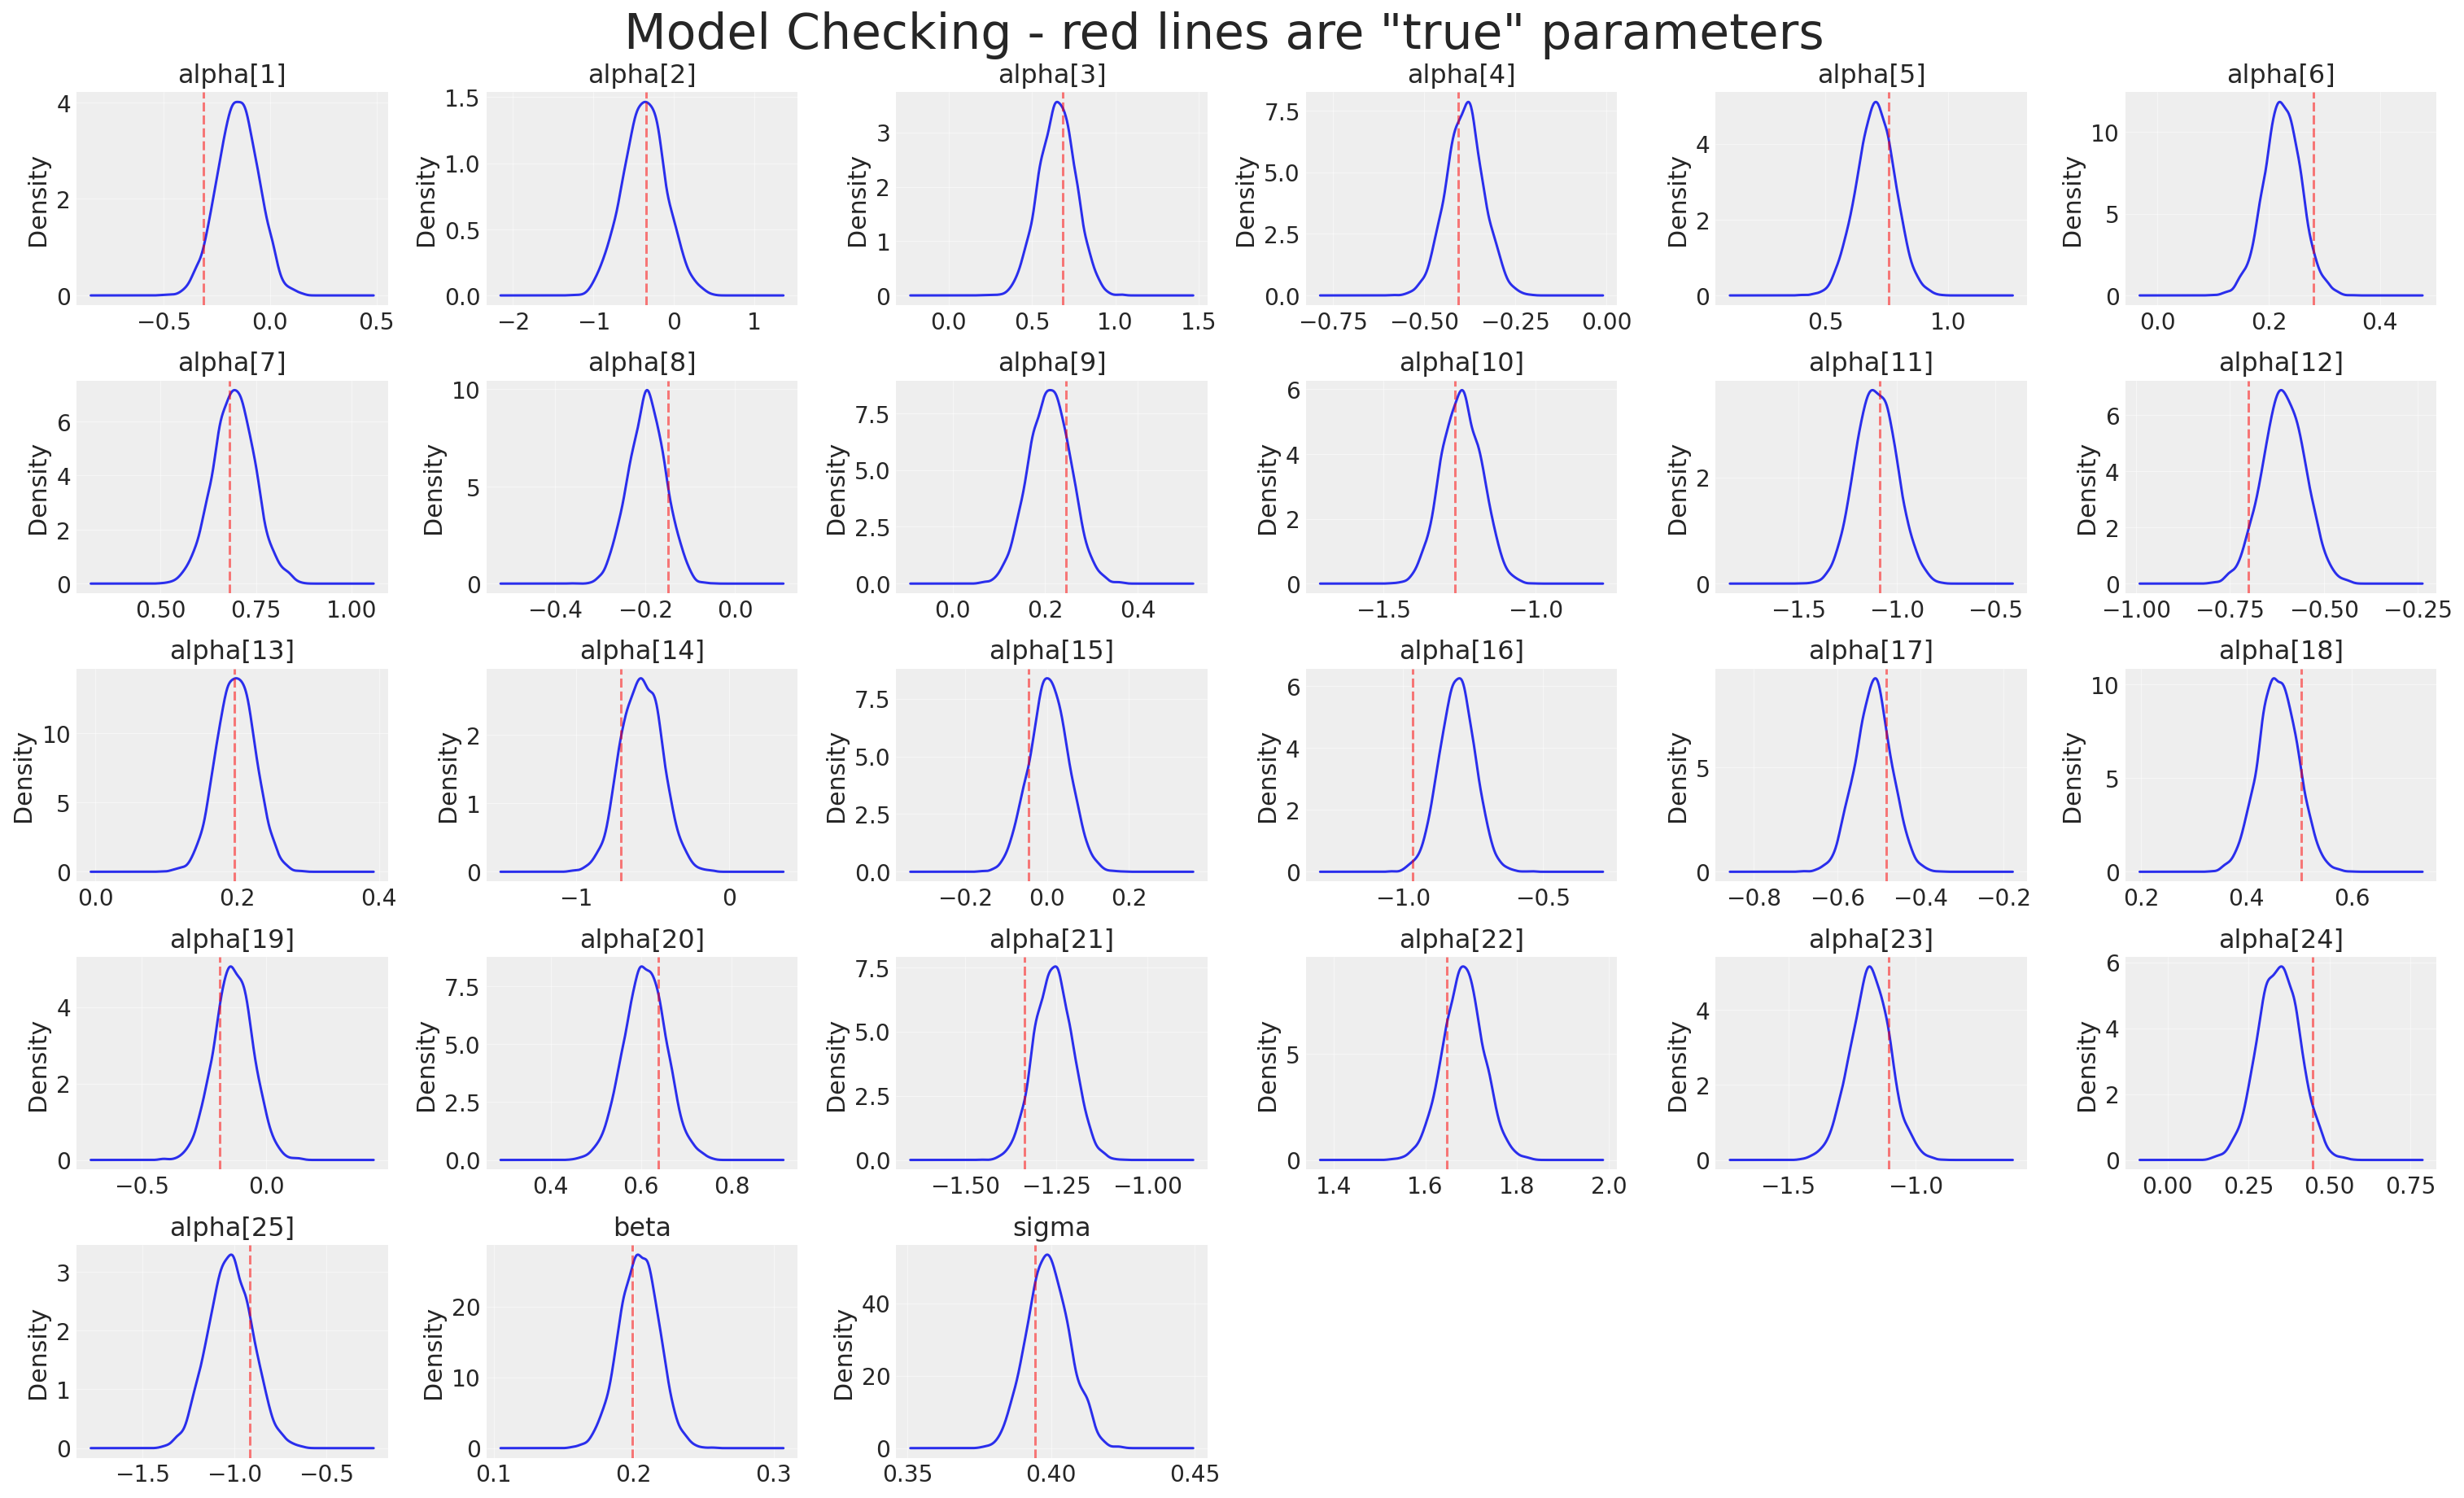

In [9]:
# Pick random simulation, let's say 10
random_draw = 50

# Extract the simulated (fake) data implied by the parameters in sample 10
y_sim = npm_df_check.filter(regex = 'y_hat').iloc[random_draw, :]

# Extract the parameteres corresponding to sample 10
true_parameters = npm_df_check.filter(regex = 'alpha|beta|sigma').iloc[random_draw, :]

# Fit the model on the fake data
_npm_data_check = dict(N = len(df),
              log_sales_price = y_sim, # this is now fitting on the extracted fake data in sample 10
              log_lot_area = df['log_lot_area_z'],
              neighbourhood = df['neighbourhood'],
              N_neighbourhood = len(df['Neighborhood'].unique()),
              alpha_sd = 1, 
              beta_sd = 1, 
              run_estimation = 1)

_fit_npm_check = no_pooling_model.sampling(data=_npm_data_check)
_npm_df_check = _fit_npm_check.to_dataframe()
fake_fit = _npm_df_check.filter(regex = 'alpha|beta|sigma')
parameter_df = pd.melt(fake_fit)

# Plot will give distributions of all parameteres to see if it can capture the known parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking - red lines are "true" parameters', size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df[['variable']].drop_duplicates().set_index('variable').index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
plt.savefig('figures/6_fit_fake_data.svg', dpi=300);

In [30]:
npm_data = dict(N = len(df),
              log_sales_price = df['log_sales_price_z'],
              log_lot_area = df['log_lot_area_z'],
              neighbourhood = df['neighbourhood'],
              N_neighbourhood = len(df['Neighborhood'].unique()),
              alpha_sd = 1, 
              beta_sd = 1, 
              run_estimation = 1)

fit_npm = no_pooling_model.sampling(data=npm_data)

npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


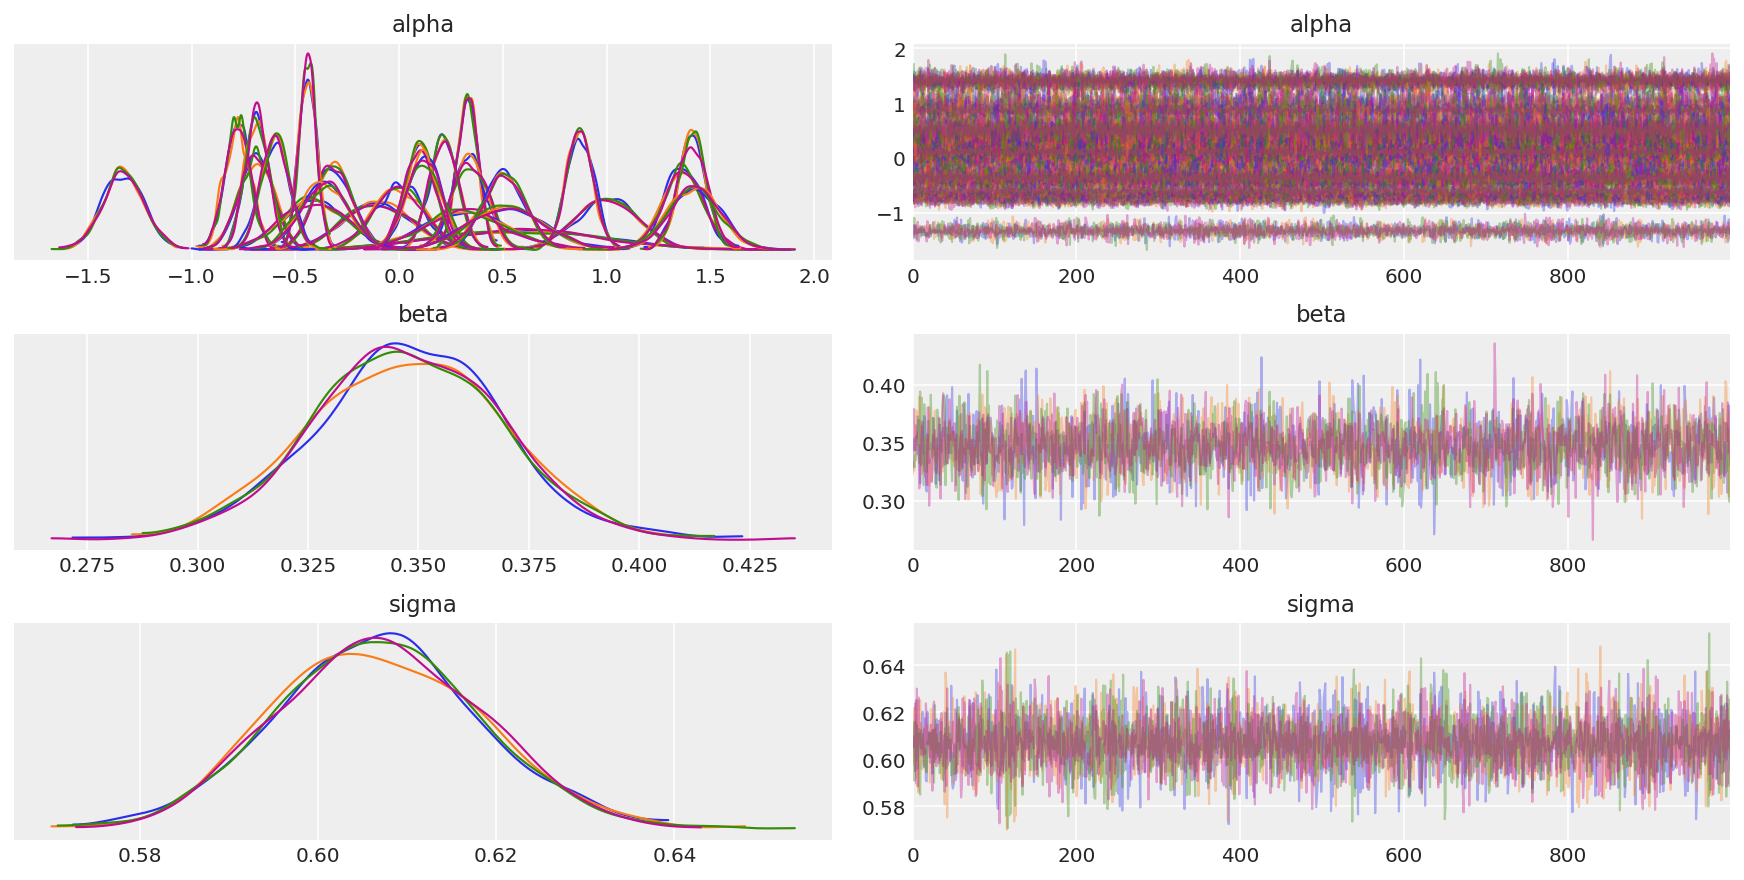

In [31]:
# Inspect model fit
az.plot_trace(fit_npm, 
              var_names=["alpha", "beta", "sigma"], 
              compact = True, 
              chain_prop = 'color')

plt.savefig('figures/7_trace_plot.svg', dpi=300);

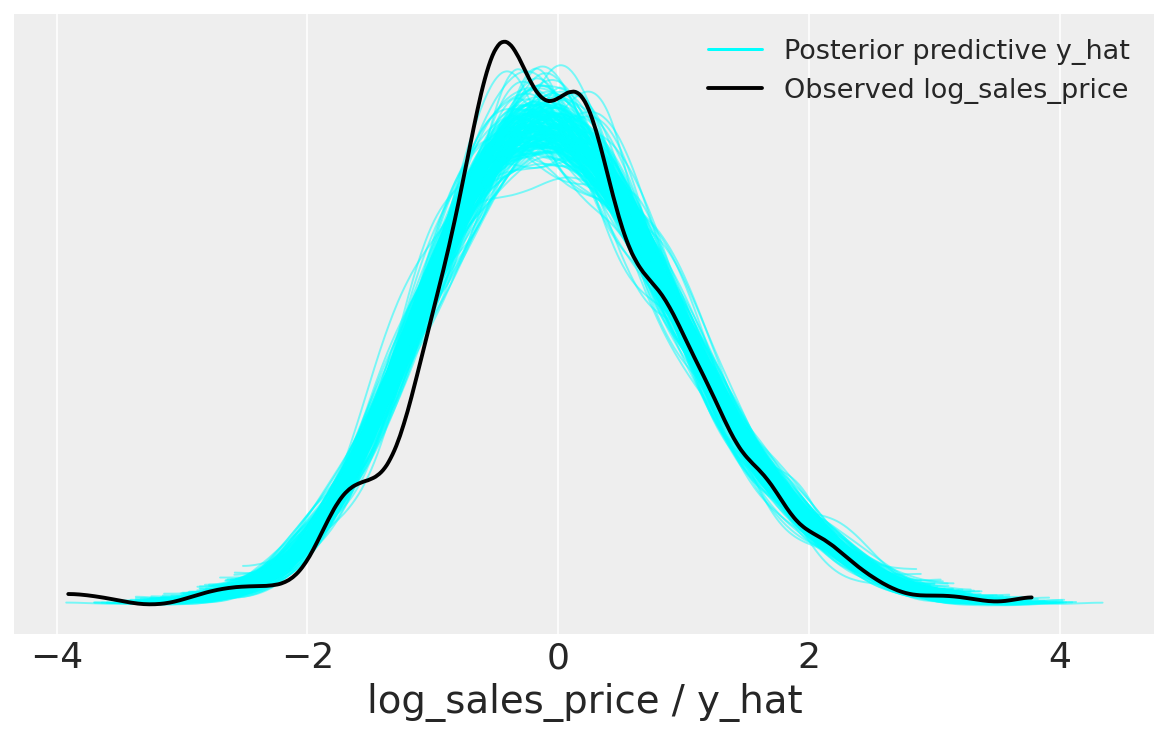

In [32]:
az.plot_ppc(data = npm_az, 
            kind = 'kde', 
            data_pairs = {'log_sales_price' : 'y_hat'},
            legend = True,
            color='cyan',
            mean = False,
            figsize=(8, 5),
            alpha = 0.5,
            num_pp_samples=200)

plt.savefig('figures/8_posterior_predictive_check.svg', dpi=300);

In [ ]:
predictions = pd.DataFrame(np.exp(fit_npm_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].std()+train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

In [36]:
np.exp(fit_npm_df.filter(regex = 'y_hat').mean(axis=0)*df['log_sales_price'].std()+df['log_sales_price'].mean()).T

y_hat[1]       186098.512278
y_hat[2]       208325.198488
y_hat[3]       201546.304196
y_hat[4]       193183.587828
y_hat[5]       326754.291791
                   ...      
y_hat[1456]    175157.215828
y_hat[1457]    192735.398057
y_hat[1458]    190524.116033
y_hat[1459]    141472.554823
y_hat[1460]    124881.356560
Length: 1460, dtype: float64

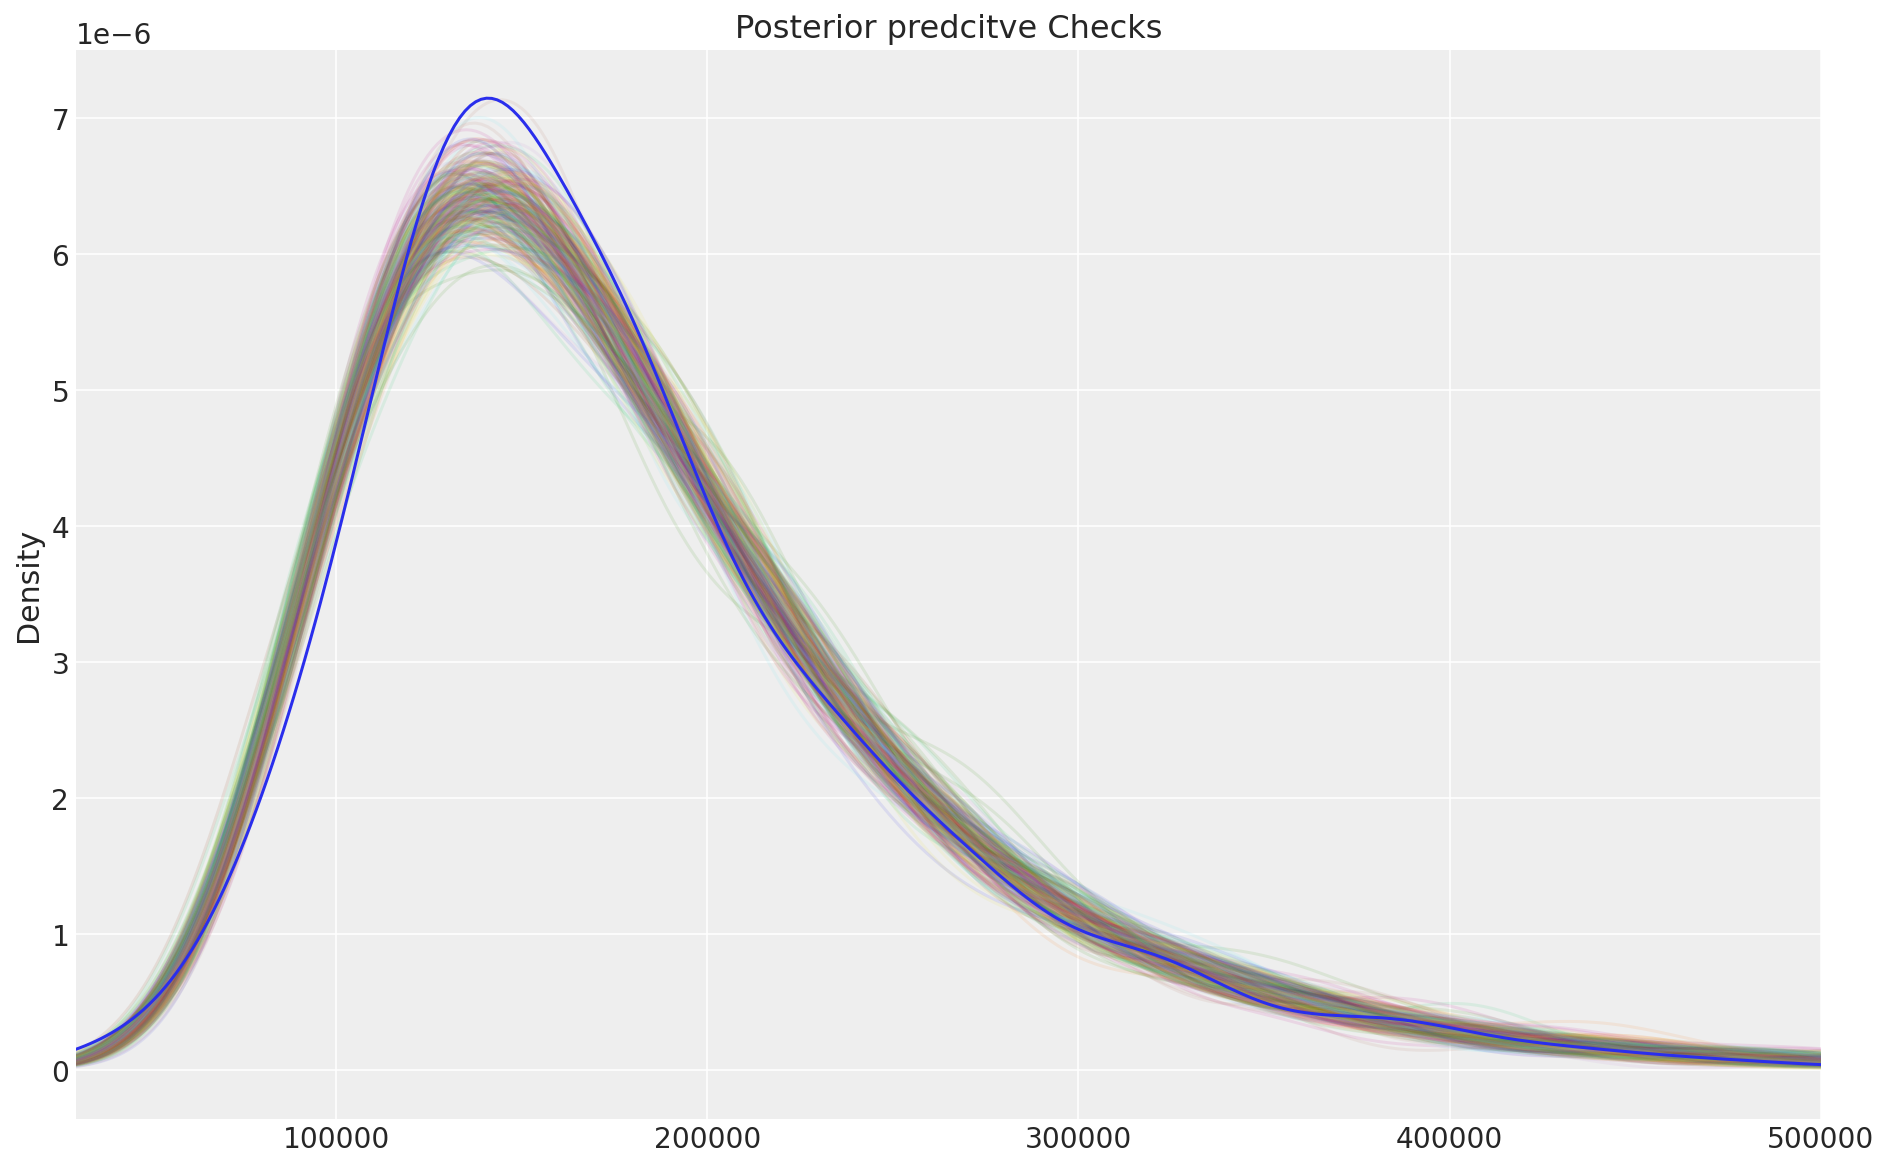

In [41]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))
np.exp(fit_npm_df.filter(regex = 'y_hat')*df['log_sales_price'].std()+df['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);

df['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

plt.savefig('figures/9_posterior_predictive_check_outcomescale.svg', dpi=300);